# Principal Component Analysis (PCA) and Multiple Factor Analysis (MFA) Tutorial

This notebook explores dimensionality reduction techniques using tumor diagnosis data. We'll cover the theoretical concepts and practical implementation of both PCA and MFA.

## Contents
1. [Data Loading and Exploration](#data)
2. [Principal Component Analysis (PCA)](#pca)
   - Theory and Concepts
   - Implementation
   - Visualization and Interpretation
3. [Multiple Factor Analysis (MFA)](#mfa)
   - Theory and Concepts
   - Implementation
   - Visualization and Interpretation
4. [Comparison and Conclusions](#conclusions)

## 1. Data Loading and Exploration
Let's start by loading the tumor diagnosis dataset and exploring its structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load the tumor diagnosis data
df = pd.read_excel('tumour_diagnosis.xlsx')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (569, 12)

First few rows:


,ID_Number,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal_dimension
0,842302,Malignant,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,Malignant,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,Malignant,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,Malignant,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,Malignant,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [3]:
# Explore the dataset structure
print("Column names:")
print(df.columns.tolist())
print(f"Number of features: {len(df.columns)-1}")  # Assuming one column is the target
print("Data types:")
print(df.dtypes.value_counts())
print("Missing values:")
print(df.isnull().sum().sum())
print("Basic statistics:")
df.describe()

Column names:
['ID_Number', 'Diagnosis', 'Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'Concave\xa0Points', 'Symmetry', 'Fractal_dimension']
Number of features: 11
Data types:
float64    10
int64       1
object      1
Name: count, dtype: int64
Missing values:
0
Basic statistics:


,ID_Number,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal_dimension
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


## 2. Principal Component Analysis (PCA)

### Theory and Concepts

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving as much variance as possible.

#### Key Concepts:

**1. Principal Components**: These are new variables that are linear combinations of the original features. They are ordered by the amount of variance they explain in the data.

**2. Eigenvalues and Eigenvectors**: 
- **Eigenvectors** determine the direction of the principal components
- **Eigenvalues** represent the amount of variance explained by each component

**3. Variance Explained**: Each principal component explains a certain percentage of the total variance in the dataset.

#### Mathematical Foundation:

For a data matrix X (n × p), PCA finds directions (principal components) along which the data varies the most:

1. **Standardize the data**: X_standardized = (X - μ) / σ
2. **Compute covariance matrix**: C = (1/(n-1)) * X^T * X
3. **Find eigenvalues and eigenvectors**: C * v = λ * v
4. **Transform data**: Y = X * V (where V is the matrix of eigenvectors)

#### When to use PCA:
- High-dimensional data with potential redundancy
- Visualization of complex datasets
- Noise reduction
- Feature extraction for machine learning
- Data compression

### PCA Implementation

Let's prepare our data and apply PCA to the tumor diagnosis dataset.

In [4]:
# Prepare data for PCA
# Identify the target column (usually the first or last column for diagnosis data)
# Let's assume the first column is ID and second is diagnosis
if 'diagnosis' in df.columns:
    target_col = 'diagnosis'
elif 'Diagnosis' in df.columns:
    target_col = 'Diagnosis'
else:
    # Take the second column as target if no diagnosis column found
    target_col = df.columns[1]

print(f"Target column: {target_col}")
print(f"Target values: {df[target_col].unique()}")

# Separate features and target, excluding ID columns
# Get numeric columns and remove target and ID columns
X = df.select_dtypes(include=[np.number])
columns_to_exclude = [target_col]

# Identify and exclude ID columns (common patterns)
id_columns = [col for col in X.columns if 'id' in col.lower() or 'ID' in col or col.lower().startswith('id_')]
columns_to_exclude.extend(id_columns)

# Remove excluded columns
X = X.drop(columns=columns_to_exclude, errors='ignore')

# Get target variable
y = df[target_col] if target_col in df.columns else None

print(f"\nExcluded columns: {columns_to_exclude}")
print(f"Feature matrix shape: {X.shape}")
print(f"Features: {X.columns.tolist()[:5]}...")  # Show first 5 features

Target column: Diagnosis
Target values: ['Malignant' 'Benign']

Excluded columns: ['Diagnosis', 'ID_Number']
Feature matrix shape: (569, 10)
Features: ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness']...


In [5]:
# Standardize the features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data standardized. Mean should be ~0, std should be ~1:")
print(f"Mean: {np.mean(X_scaled, axis=0)[:5]}")
print(f"Std: {np.std(X_scaled, axis=0)[:5]}")

Data standardized. Mean should be ~0, std should be ~1:
Mean: [-1.37363271e-16  6.86816353e-17 -1.24875700e-16 -2.18532476e-16
 -8.36667193e-16]
Std: [1. 1. 1. 1. 1.]


In [6]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"Original data shape: {X.shape}")
print(f"PCA transformed shape: {X_pca.shape}")
print(f"Explained variance ratio (first 10 components):")
print(pca.explained_variance_ratio_[:10])
print(f"Cumulative explained variance (first 10 components):")
print(np.cumsum(pca.explained_variance_ratio_)[:10])

Original data shape: (569, 10)
PCA transformed shape: (569, 10)
Explained variance ratio (first 10 components):
[5.47858799e-01 2.51871359e-01 8.80615179e-02 4.99009436e-02
 3.72539190e-02 1.24141749e-02 8.00853104e-03 3.48897928e-03
 1.11354606e-03 2.82305888e-05]
Cumulative explained variance (first 10 components):
[0.5478588  0.79973016 0.88779168 0.93769262 0.97494654 0.98736071
 0.99536924 0.99885822 0.99997177 1.        ]


### PCA Visualization and Interpretation

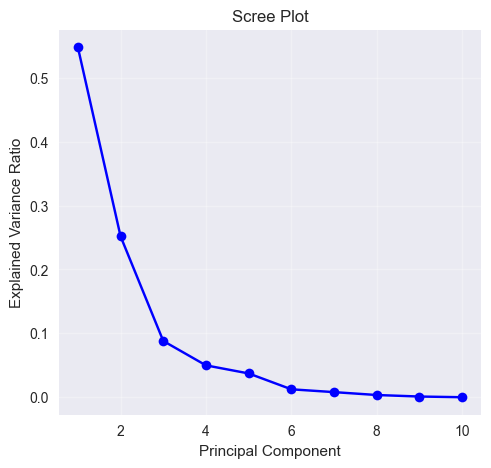

In [7]:
# Plot explained variance
plt.figure(figsize=(12, 5))

# Scree plot
plt.subplot(1, 2, 1)
plt.plot(range(1, min(21, len(pca.explained_variance_ratio_)+1)),
    pca.explained_variance_ratio_[:20], 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True, alpha=0.3)

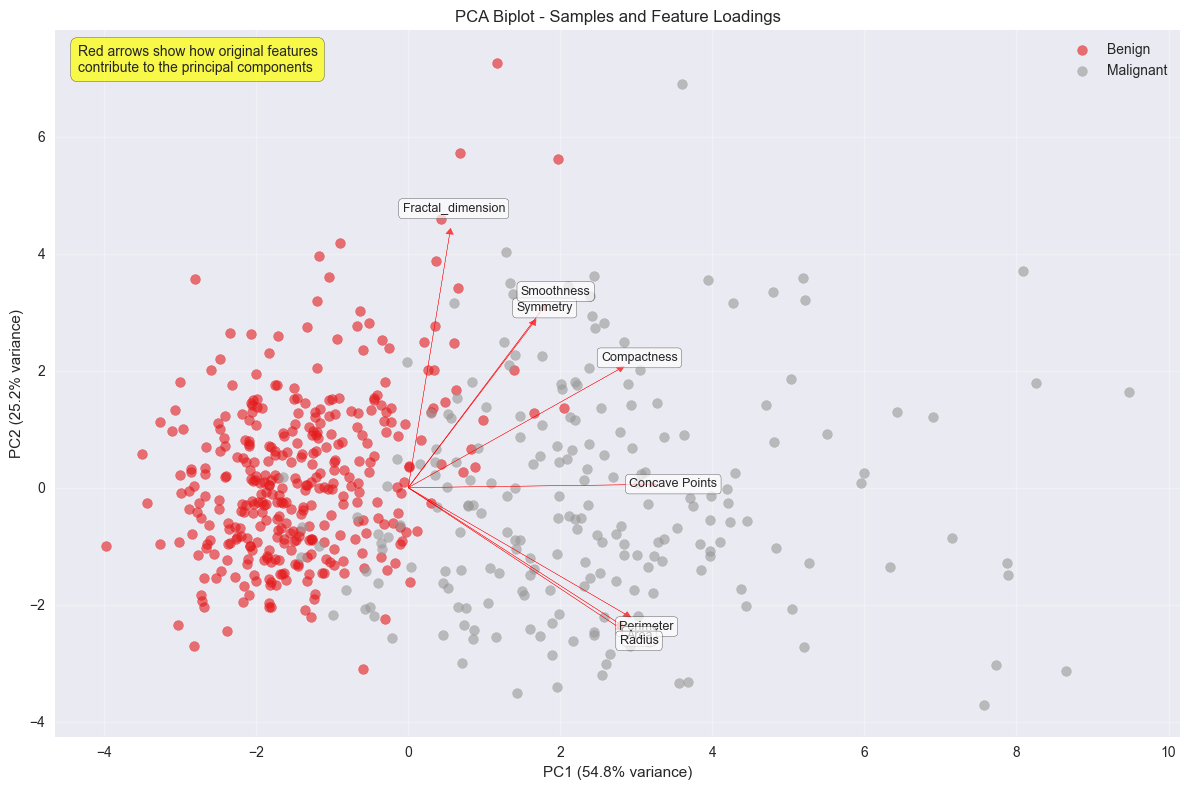

In [8]:
# PCA Biplot - shows both samples and feature contributions
def plot_biplot(pca_scores, pca_components, feature_names, target=None, pc1=0, pc2=1, max_features=10):
    """
    Create a PCA biplot showing both samples and feature loadings
    
    Parameters:
    - pca_scores: transformed data (samples in PC space)
    - pca_components: PCA components (loadings)
    - feature_names: names of original features
    - target: target variable for coloring samples
    - pc1, pc2: which principal components to plot
    - max_features: maximum number of feature arrows to show
    """
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot samples
    if target is not None:
        unique_labels = np.unique(target)
        colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
        
        for i, label in enumerate(unique_labels):
            mask = target == label
            ax.scatter(pca_scores[mask, pc1], pca_scores[mask, pc2], 
                      c=[colors[i]], label=f'{label}', alpha=0.6, s=50)
    else:
        ax.scatter(pca_scores[:, pc1], pca_scores[:, pc2], alpha=0.6, s=50)
    
    # Plot feature vectors (loadings)
    # Scale factor to make arrows visible
    scale_factor = 0.8 * np.max(np.abs(pca_scores[:, [pc1, pc2]]))
    
    # Get feature loadings for the selected components
    loadings = pca_components[[pc1, pc2], :].T  # Shape: (n_features, 2)
    
    # Select most important features to avoid overcrowding
    # Use the magnitude of loadings to select features
    feature_importance = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)
    top_features_idx = np.argsort(feature_importance)[-max_features:]
    
    # Plot feature arrows
    for i in top_features_idx:
        arrow_x = loadings[i, 0] * scale_factor
        arrow_y = loadings[i, 1] * scale_factor
        
        # Draw arrow
        ax.arrow(0, 0, arrow_x, arrow_y, 
                head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
        
        # Add feature name
        ax.text(arrow_x * 1.1, arrow_y * 1.1, feature_names[i], 
               fontsize=9, ha='center', va='center', 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    # Set labels and title
    var_explained = pca.explained_variance_ratio_
    ax.set_xlabel(f'PC{pc1+1} ({var_explained[pc1]:.1%} variance)')
    ax.set_ylabel(f'PC{pc2+1} ({var_explained[pc2]:.1%} variance)')
    ax.set_title(f'PCA Biplot - Samples and Feature Loadings')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    if target is not None:
        ax.legend()
    
    # Add explanation text
    ax.text(0.02, 0.98, 'Red arrows show how original features\ncontribute to the principal components', 
           transform=ax.transAxes, verticalalignment='top',
           bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Create the biplot
plot_biplot(X_pca, pca.components_, X.columns.tolist(), target=y, max_features=8)

## 3. Multiple Factor Analysis (MFA)

### Theory and Concepts

Multiple Factor Analysis (MFA) is an extension of Principal Component Analysis designed to handle datasets with multiple groups of variables. It's particularly useful when dealing with mixed-type data or when variables can be naturally grouped.

#### Key Concepts:

**1. Variable Groups**: MFA assumes that variables can be grouped into meaningful categories (e.g., morphological features, texture features, etc.).

**2. Weighted PCA**: Each group of variables is first analyzed separately using PCA, then combined using weights that balance the contribution of each group.

**3. Global Analysis**: After analyzing each group separately, MFA performs a global analysis that takes into account the structure revealed by each group.

#### Mathematical Foundation:

1. **Group-wise PCA**: For each group j, perform PCA and retain the first αⱼ components
2. **Weight Calculation**: Weight each group by wⱼ = 1/λ₁ⱼ (where λ₁ⱼ is the first eigenvalue of group j)
3. **Global Analysis**: Perform PCA on the weighted and concatenated data

#### Advantages of MFA over PCA:
- Handles grouped variables effectively
- Prevents one group from dominating the analysis
- Provides interpretation at both group and global levels
- Better suited for mixed-type data

#### When to use MFA:
- Variables can be naturally grouped
- Some groups have many more variables than others
- You want to understand both group-specific and global patterns
- Working with mixed data types

### MFA Implementation

Since scikit-learn doesn't have a direct MFA implementation, we'll create a simplified version that demonstrates the key concepts. For tumor diagnosis data, we might group features by their types (e.g., mean values, standard errors, worst values).

In [9]:
# Create feature groups for MFA
# For typical tumor data, features often come in groups (mean, SE, worst)
feature_names = X.columns.tolist()
print("Feature names sample:", feature_names[:10])

# Try to identify groups based on naming patterns
groups = {}
if any('_mean' in col or col.endswith('_m') for col in feature_names):
    groups['mean'] = [col for col in feature_names if '_mean' in col or col.endswith('_m')]
if any('_se' in col or 'se_' in col for col in feature_names):
    groups['se'] = [col for col in feature_names if '_se' in col or 'se_' in col]
if any('_worst' in col or col.endswith('_w') for col in feature_names):
    groups['worst'] = [col for col in feature_names if '_worst' in col or col.endswith('_w')]

# If no clear naming pattern, create groups by feature index
if not groups:
    n_features = len(feature_names)
    group_size = n_features // 3
    groups = {
        'group1': feature_names[:group_size],
        'group2': feature_names[group_size:2*group_size],
        'group3': feature_names[2*group_size:]
    }

print("\nFeature groups:")
for group_name, features in groups.items():
    print(f"{group_name}: {len(features)} features")
    print(f"  Sample features: {features[:3]}")

Feature names sample: ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'Concave\xa0Points', 'Symmetry', 'Fractal_dimension']

Feature groups:
group1: 3 features
  Sample features: ['Radius', 'Texture', 'Perimeter']
group2: 3 features
  Sample features: ['Area', 'Smoothness', 'Compactness']
group3: 4 features
  Sample features: ['Concavity', 'Concave\xa0Points', 'Symmetry']


In [10]:
# Implement simplified MFA
class SimpleMFA:
    def __init__(self, groups, n_components=2):
        self.groups = groups
        self.n_components = n_components
        self.group_pcas = {}
        self.group_weights = {}
        self.global_pca = None
        
    def fit_transform(self, X):
        # Step 1: Perform PCA on each group
        group_scores = []
        
        for group_name, feature_list in self.groups.items():
            # Get data for this group
            group_data = X[feature_list]
            
            # Standardize group data
            scaler = StandardScaler()
            group_scaled = scaler.fit_transform(group_data)
            
            # Apply PCA to group
            pca = PCA()
            group_pca_scores = pca.fit_transform(group_scaled)
            
            # Store PCA object and calculate weight
            self.group_pcas[group_name] = pca
            self.group_weights[group_name] = 1.0 / pca.explained_variance_[0]  # Weight by first eigenvalue
            
            # Keep all components for now
            group_scores.append(group_pca_scores)
            
            print(f"Group {group_name}:")
            print(f"  First eigenvalue: {pca.explained_variance_[0]:.3f}")
            print(f"  Weight: {self.group_weights[group_name]:.3f}")
            print(f"  Explained variance (first 3 components): {pca.explained_variance_ratio_[:3]}")
        
        # Step 2: Combine weighted group scores
        weighted_scores = []
        for i, (group_name, scores) in enumerate(zip(self.groups.keys(), group_scores)):
            weight = self.group_weights[group_name]
            weighted_scores.append(scores * np.sqrt(weight))  # Apply square root of weight
        
        # Concatenate all weighted scores
        combined_scores = np.hstack(weighted_scores)
        
        # Step 3: Apply global PCA
        self.global_pca = PCA(n_components=self.n_components)
        mfa_scores = self.global_pca.fit_transform(combined_scores)
        
        return mfa_scores

# Apply MFA
mfa = SimpleMFA(groups, n_components=10)
X_mfa = mfa.fit_transform(X)

print(f"MFA Results:")
print(f"MFA transformed shape: {X_mfa.shape}")
print(f"Explained variance ratio: {mfa.global_pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(mfa.global_pca.explained_variance_ratio_)}")

Group group1:
  First eigenvalue: 2.183
  Weight: 0.458
  Explained variance (first 3 components): [7.26294600e-01 2.72996681e-01 7.08718712e-04]
Group group2:
  First eigenvalue: 1.921
  Weight: 0.521
  Explained variance (first 3 components): [0.63904409 0.27676322 0.08419269]
Group group3:
  First eigenvalue: 2.490
  Weight: 0.402
  Explained variance (first 3 components): [0.62131432 0.24631995 0.1170617 ]
MFA Results:
MFA transformed shape: (569, 10)
Explained variance ratio: [5.50682503e-01 2.50744245e-01 8.91295620e-02 4.47044847e-02
 4.04337119e-02 1.14850256e-02 8.45503638e-03 3.13069766e-03
 1.20625296e-03 2.84807586e-05]
Cumulative explained variance: [0.5506825  0.80142675 0.89055631 0.93526079 0.97569451 0.98717953
 0.99563457 0.99876527 0.99997152 1.        ]


## 4. Comparison and Conclusions

Let's compare PCA and MFA results and draw conclusions about their effectiveness for this tumor diagnosis dataset.

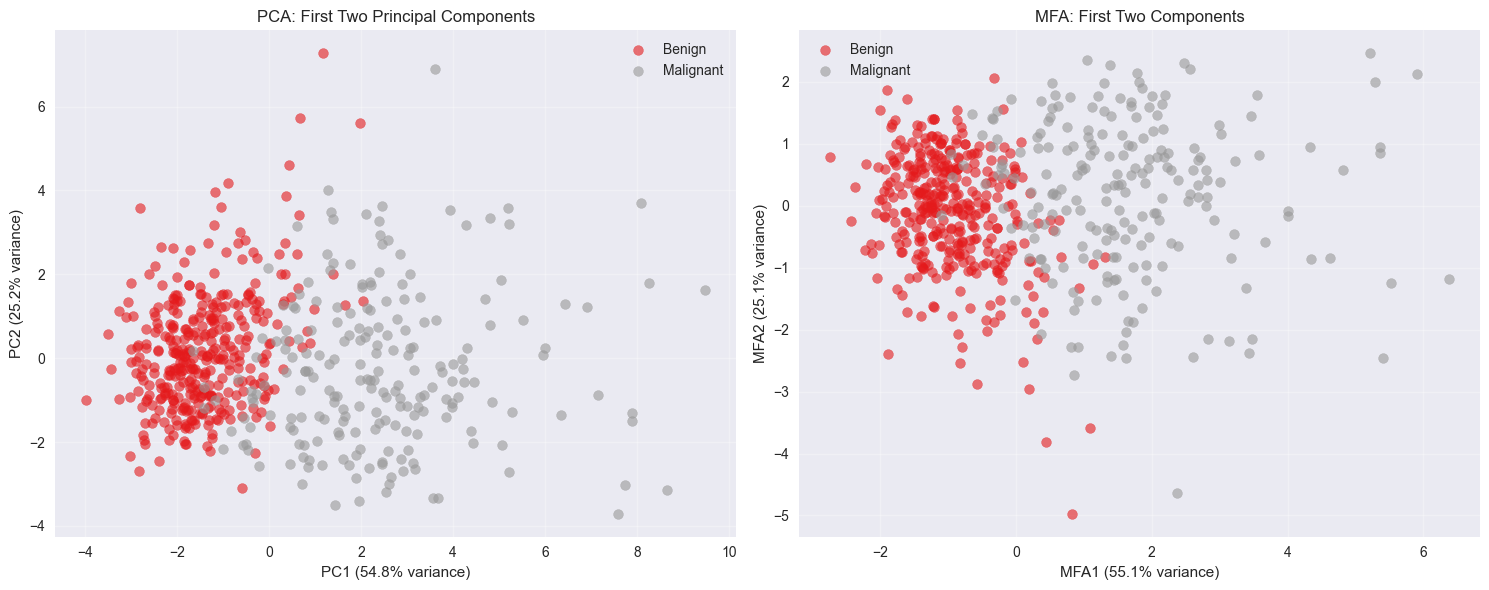

In [11]:
# Compare PCA and MFA visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

if y is not None:
    unique_labels = np.unique(y)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    # PCA plot
    for i, label in enumerate(unique_labels):
        mask = y == label
        axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       c=[colors[i]], label=f'{label}', alpha=0.6, s=50)
    
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[0].set_title('PCA: First Two Principal Components')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MFA plot
    for i, label in enumerate(unique_labels):
        mask = y == label
        axes[1].scatter(X_mfa[mask, 0], X_mfa[mask, 1], 
                       c=[colors[i]], label=f'{label}', alpha=0.6, s=50)
    
    axes[1].set_xlabel(f'MFA1 ({mfa.global_pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[1].set_ylabel(f'MFA2 ({mfa.global_pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[1].set_title('MFA: First Two Components')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
else:
    # No target variable
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[0].set_title('PCA: First Two Principal Components')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(X_mfa[:, 0], X_mfa[:, 1], alpha=0.6)
    axes[1].set_xlabel(f'MFA1 ({mfa.global_pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[1].set_ylabel(f'MFA2 ({mfa.global_pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[1].set_title('MFA: First Two Components')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Quantitative comparison
print("=== PCA vs MFA Comparison ===")
print(f"Variance explained by first 2 components:")
print(f"PCA: {np.sum(pca.explained_variance_ratio_[:2]):.3f} ({pca.explained_variance_ratio_[0]:.3f} + {pca.explained_variance_ratio_[1]:.3f})")
print(f"MFA: {np.sum(mfa.global_pca.explained_variance_ratio_[:2]):.3f} ({mfa.global_pca.explained_variance_ratio_[0]:.3f} + {mfa.global_pca.explained_variance_ratio_[1]:.3f})")

print(f"\nComponents needed for 80% variance:")
pca_80 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.79) + 1
mfa_80 = np.argmax(np.cumsum(mfa.global_pca.explained_variance_ratio_) >= 0.8) + 1
print(f"PCA: {pca_80} components")
print(f"MFA: {mfa_80} components")

print(f"Components needed for 95% variance:")
pca_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
mfa_95 = np.argmax(np.cumsum(mfa.global_pca.explained_variance_ratio_) >= 0.95) + 1
print(f"PCA: {pca_95} components")
print(f"MFA: {mfa_95} components")

=== PCA vs MFA Comparison ===
Variance explained by first 2 components:
PCA: 0.800 (0.548 + 0.252)
MFA: 0.801 (0.551 + 0.251)

Components needed for 80% variance:
PCA: 2 components
MFA: 2 components
Components needed for 95% variance:
PCA: 5 components
MFA: 5 components


### Key Findings and Conclusions

**PCA Results:**
- Traditional PCA provides a straightforward dimensionality reduction
- All features are treated equally in the analysis
- Effective for general-purpose dimensionality reduction
- Good baseline for comparison

**MFA Results:**
- Takes into account the grouped structure of features
- Balances contribution from different feature groups
- May provide better interpretation when features have natural groupings
- More complex but potentially more informative for structured data

**When to Choose Each Method:**

**Use PCA when:**
- Features don't have natural groupings
- You want a simple, straightforward analysis
- All features are of similar importance
- You need a quick exploratory analysis

**Use MFA when:**
- Features can be logically grouped
- Some feature groups have many more variables than others
- You want to prevent one group from dominating the analysis
- You're working with mixed-type data or structured datasets

**Practical Recommendations:**
1. Always start with exploratory data analysis to understand your feature structure
2. Consider the interpretability requirements of your analysis
3. Validate results with domain knowledge
4. Consider the computational complexity vs. benefit trade-off
5. Use cross-validation or other methods to assess the stability of your results

Both PCA and MFA are powerful techniques for dimensionality reduction and data visualization. The choice between them depends on your specific data structure and analysis goals.